# Distributed Cell Tally Visualization

This example demonstrates how a tally with a `DistribcellFilter` can be plotted using the `openmc.lib` module to determine geometry information. First, we'll begin by creating a simple model with a hexagonal lattice.

In [1]:
from pprint import pprint

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import openmc
import openmc.lib

Our model will have two materials, fuel and water:

In [2]:
fuel = openmc.Material(name='fuel')
fuel.add_nuclide('U235', 1.0)
fuel.set_density('g/cm3', 10.0)

water = openmc.Material(name='water')
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)

mats = openmc.Materials((fuel, water))
mats.export_to_xml()

We'll create two universes for use in our hexaongal lattice, one which has a pin consisting of fuel and one which is entirely water.

In [3]:
r_pin = openmc.ZCylinder(r=0.25)
fuel_cell = openmc.Cell(fill=fuel, region=-r_pin)
water_cell = openmc.Cell(fill=water, region=+r_pin)
pin_universe = openmc.Universe(cells=(fuel_cell, water_cell))

all_water_cell = openmc.Cell(fill=water)
water_universe = openmc.Universe(cells=(all_water_cell,))

Now let's create a hexagonal lattice with three rings that is otherwise surrounded by water.

In [4]:
lat = openmc.HexLattice()
lat.center = (0., 0.)
lat.pitch = [1.25]
lat.outer = water_universe
outer_ring = [pin_universe]*12
middle_ring = [pin_universe]*6
inner_ring = [pin_universe]
lat.universes = [outer_ring, middle_ring, inner_ring]

Now let's put our lattice inside a cylindrical cell so that is properly contained. This completes the geometry.

In [5]:
outer_radius = 4.0
outer_surface = openmc.ZCylinder(r=outer_radius, boundary_type='vacuum')
main_cell = openmc.Cell(fill=lat, region=-outer_surface)
geom = openmc.Geometry([main_cell])
geom.export_to_xml()

To see what our geometry looks like, we can plot it:

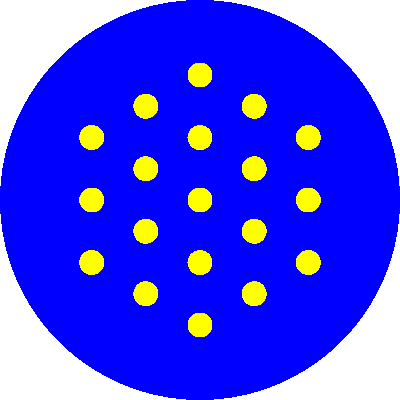

In [6]:
p = openmc.Plot.from_geometry(geom)
p.color_by = 'material'
p.colors = {
    fuel: 'yellow',
    water: 'blue'
}
p.to_ipython_image()

Great! Now to finish things, we just need to create some simulation settings and setup a tally with a distribcell filter. Beginning with the simulation settings:

In [7]:
settings = openmc.Settings()
settings.batches = 25
settings.inactive = 5
settings.particles = 10000
settings.source = openmc.Source(space=openmc.stats.Point((0., 0., 0.)))
settings.export_to_xml()

Our tally will use a distribcell filter over the `fuel_cell`, and we'll tally the flux as the only score.

In [8]:
tally = openmc.Tally()
tally.filters = [openmc.DistribcellFilter(fuel_cell)]
tally.scores = ['flux']

tallies = openmc.Tallies([tally])
tallies.export_to_xml()

We're ready to run the transport simulation and get tally results to plot.

In [9]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Now that the simulation is finished, we need to pull the resulting flux data out of the statepoint file that was produced. Since we only have a single score and a single filter, this is especially easy because we can just take the `.mean` attribute of a `Tally` object and flatten it using the `ravel()` method for numpy arrays. While we're at it, we'll get a Pandas dataframe to see what the results look like.

In [10]:
with openmc.StatePoint('statepoint.25.h5') as sp:
    # Get the Tally object
    t = sp.tallies[1]
    
    # Get the mean value of the flux for each instance of the fuel cell as a flattened (1D) numpy array
    flux = t.mean.ravel()
    
    # Show a Pandas dataframe
    df = t.get_pandas_dataframe()    
    print(df)

   level 1      level 2       level 3      distribcell nuclide score     mean  \
      univ cell     lat          univ cell                                      
        id   id      id  x  y      id   id                                      
0        4    4       3  0 -2       1    1           0   total  flux 3.71e-02   
1        4    4       3  1 -2       1    1           1   total  flux 4.00e-02   
2        4    4       3  2 -2       1    1           2   total  flux 3.46e-02   
3        4    4       3 -1 -1       1    1           3   total  flux 3.97e-02   
4        4    4       3  0 -1       1    1           4   total  flux 4.73e-02   
5        4    4       3  1 -1       1    1           5   total  flux 4.79e-02   
6        4    4       3  2 -1       1    1           6   total  flux 3.99e-02   
7        4    4       3 -2  0       1    1           7   total  flux 3.62e-02   
8        4    4       3 -1  0       1    1           8   total  flux 4.83e-02   
9        4    4       3  0  

Now it's time to actually try to plot the data. There's no "easy" way to do this, but the technique we'll use is to loop over a bunch of (x, y, z) points, determine what cell/instance corresponds to each point, and create a 2D array with the flux values where the cell/instance matches one of the bins of our tally. First, let's set the resolution of our desired image and create an array of the appropriate size filled in with "null" values indicated by `np.nan` (matplotlib won't plot data anywhere it sees nan values). When an (x, y, z) point corresponds to a cell/instance that we tallied, we'll set the corresponding pixel in the image.

In [11]:
resolution = (600, 600)
img = np.full(resolution, np.nan)
xmin, xmax = -3., 3.
ymin, ymax = -3., 3.

In order to determine the cell/instance for a given (x, y, z) point, we need to use the `find_cell` function from `openmc.lib`. Calls to `find_cell` return a tuple of two values, a `Cell` object and distribcell index that can be used to determine the appropriate bin from the tally. Note that we actually have to initialize the OpenMC library (which reads the XML files) in order to use this function. We'll use the `run_in_memory()` context manager, which will call `openmc.lib.init()` and `openmc.lib.finalize()` before and after the `with` block, respectively.

In [12]:
with openmc.lib.run_in_memory():
    for row, y in enumerate(np.linspace(ymin, ymax, resolution[0])):
        for col, x in enumerate(np.linspace(xmin, xmax, resolution[1])):
            try:
                # For each (x, y, z) point, determine the cell and distribcell index
                cell, distribcell_index = openmc.lib.find_cell((x, y, 0.))
            except openmc.exceptions.GeometryError:
                # If a point appears outside the geometry, you'll get a GeometryError exception.
                # These lines catch the exception and continue on
                continue

            if cell.id == fuel_cell.id:
                # When the cell ID matches, we set the corresponding pixel in the image using the
                # distribcell index. Note that we're taking advantage of the fact that the i-th element
                # in the flux array corresponds to the i-th distribcell instance.
                img[row, col] = flux[distribcell_index]


Now plot the image. Because we looped over y values from the bottom to top, we need to specify that the origin corresponds to the lower-left corner rather than the upper-left corner. We'll also set a few optional arguments to make the plot nicer.

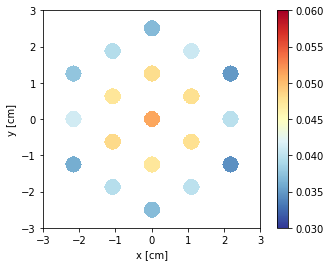

In [13]:
options = {
    'origin': 'lower',
    'extent': (xmin, xmax, ymin, ymax),
    'vmin': 0.03,
    'vmax': 0.06,
    'cmap': 'RdYlBu_r',
}
plt.imshow(img, **options)
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.colorbar()

Success! As expected, the highest flux is observed in the center of the model.

## Cell Instance Filters

This same technique can be used with a `CellInstanceFilter` with a slight modification. With a `CellInstanceFilter`, we cannot assume the index in the flux array will corresponding directly to the distribcell index. As such, we'll need to create mapping of the distribcell index to the flux array index. Let's go through such an example. First, let's create a new tally with a `CellInstanceFilter` that requests every other instance of the fuel cell rather than all of them (as is the default for a `DistribcellFilter`):

In [14]:
# Create a cell instance
cell_instances = [(fuel_cell, i) for i in range(0, 18, 2)]
cellinst_filter = openmc.CellInstanceFilter(cell_instances)

instance_tally = openmc.Tally()
instance_tally.filters = [cellinst_filter]
instance_tally.scores = ['flux']

# Add to existing Tallies object and re-export
tallies.append(instance_tally)
tallies.export_to_xml()

Let's re-run OpenMC to generate a new statepoint and get the results from the statepoint as before:

In [15]:
openmc.run(output=False)

with openmc.StatePoint('statepoint.25.h5') as sp:
    t = sp.tallies[2]
    flux_inst = t.mean.ravel()
    
    df = t.get_pandas_dataframe()
    print(df)

  cellinstance          nuclide score     mean std. dev.
          cell instance                                 
0            1        0   total  flux 3.71e-02  4.11e-04
1            1        2   total  flux 3.46e-02  5.68e-04
2            1        4   total  flux 4.73e-02  5.93e-04
3            1        6   total  flux 3.99e-02  3.57e-04
4            1        8   total  flux 4.83e-02  4.51e-04
5            1       10   total  flux 4.79e-02  4.58e-04
6            1       12   total  flux 4.12e-02  5.54e-04
7            1       14   total  flux 4.81e-02  4.38e-04
8            1       16   total  flux 3.77e-02  3.89e-04


We see that in this case, the i-th value in the array of fluxes is **not** the i-th distribcell instance, so we need to create a dictionary mapping the instance to the index to be used later when plotting.

In [16]:
instance = df['cellinstance']['instance']
instance_to_index = dict(zip(instance.values, instance.index))
pprint(instance_to_index, width=1)

{0: 0,
 2: 1,
 4: 2,
 6: 3,
 8: 4,
 10: 5,
 12: 6,
 14: 7,
 16: 8}


The code for plotting will look exactly the same, except that when we set `img[row, col]` we first need to use the `instance_to_index` mapping to determine the appropriate index:

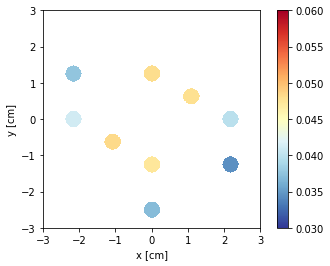

In [17]:
img[:] = np.nan
with openmc.lib.run_in_memory():
    for row, y in enumerate(np.linspace(ymin, ymax, resolution[0])):
        for col, x in enumerate(np.linspace(xmin, xmax, resolution[1])):
            try:
                # For each (x, y, z) point, determine the cell and distribcell index
                cell, distribcell_index = openmc.lib.find_cell((x, y, 0.))
            except openmc.exceptions.GeometryError:
                # If a point appears outside the geometry, you'll get a GeometryError exception.
                # These lines catch the exception and assign a "null" value for the array
                continue

            if cell.id == fuel_cell.id:
                # When the cell ID matches, we set the corresponding pixel in the image using the
                # distribcell index. NOTE: In this case, we need to use the dictionary to find the
                # proper index in the flux array
                index = instance_to_index.get(distribcell_index)
                if index is not None:
                    # If the distribcell instance was specified in our filter, get the flux value
                    img[row, col] = flux_inst[index]

# Plot the image using the same options as before. Notably, this ensures that the colors are consistent.
plt.imshow(img, **options)
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.colorbar()